In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import folium
from folium import plugins
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

#!pip install jupyternotify
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
## Run %%notify to create notification for completed cell
%notify

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
calendar = pd.read_csv('Data/seattle_airbnb/calendar.csv', parse_dates=[1])
listings = pd.read_csv('Data/seattle_airbnb/listings.csv')
reviews = pd.read_csv('Data/seattle_airbnb/reviews.csv', parse_dates=[2])

In [3]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB


In [5]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [6]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [7]:
worthless_info = listings[['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 
                           'picture_url', 'xl_picture_url', 'neighbourhood_cleansed',
                           'neighbourhood_group_cleansed', 'country_code', 'country', 'is_location_exact',
                           'calendar_last_scraped', 'license', 'jurisdiction_names', 'square_feet',
                           'notes', 'neighborhood_overview']]
host_info = listings[['host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
                      'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
                      'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count',
                      'host_verifications', 'host_has_profile_pic', 'host_identity_verified']]

In [8]:
drop = pd.concat([worthless_info, host_info], axis=1)
drop = drop.columns
drop

Index(['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'country_code', 'country',
       'is_location_exact', 'calendar_last_scraped', 'license',
       'jurisdiction_names', 'square_feet', 'notes', 'neighborhood_overview',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified'],
      dtype='object')

In [9]:
listings = listings.drop(drop, axis=1)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 57 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      3818 non-null object
latitude                            38

In [10]:
listings.isna().sum()

id                                     0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
transit                              934
host_total_listings_count              2
street                                 0
neighbourhood                        416
city                                   0
state                                  0
zipcode                                7
market                                 0
smart_location                         0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                             16
bedrooms                               6
beds                                   1
bed_type                               0
amenities       

In [11]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [12]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB


In [13]:
marks = listings[['latitude', 'longitude', 'id', 'price', 'property_type', 'bedrooms', 'bathrooms']]
marks['price'] = marks['price'].apply(lambda s: s.replace('$', '').replace(',', '')).astype('float')
marks['property_type'] = marks['property_type'].replace({'Townhouse': 'Other', 
                                                         'Bungalow': 'Other',
                                                         'Condominium': 'Other', 
                                                         'Camper/RV': 'Other',
                                                         'Cabin': 'Other'})
marks.head()

,latitude,longitude,id,price,property_type,bedrooms,bathrooms
0,47.636289,-122.371025,241032,85.0,Apartment,1.0,1.0
1,47.639123,-122.365666,953595,150.0,Apartment,1.0,1.0
2,47.629724,-122.369483,3308979,975.0,House,5.0,4.5
3,47.638473,-122.369279,7421966,100.0,Apartment,0.0,1.0
4,47.632918,-122.372471,278830,450.0,House,3.0,2.0


In [14]:
locations = marks[['latitude', 'longitude']]
locationlist = locations.values.tolist()
print(len(locationlist))
locationlist[:5]

3818


[[47.636289038357184, -122.37102519997765],
 [47.63912312136253, -122.36566646439582],
 [47.629724131577355, -122.3694831756176],
 [47.63847320176642, -122.36927912263019],
 [47.63291840276724, -122.37247063402224]]

In [15]:
marks.loc[1]

latitude           47.6391
longitude         -122.366
id                  953595
price                  150
property_type    Apartment
bedrooms                 1
bathrooms                1
Name: 1, dtype: object

In [16]:
#if(not os.path.exists('Maps/airbnb_cluster.html')):
clusters=folium.Map(location=[listings.latitude.mean(),listings.longitude.mean()],
                  zoom_start=11,tiles='OpenStreetMap')
plugins.MarkerCluster(locationlist).add_to(clusters)
plugins.ScrollZoomToggler().add_to(clusters)
clusters.save(os.path.join('Maps/', 'airbnb_cluster.html'))
clusters

In [17]:
#if(not os.path.exists('Maps/airbnb_ind_1.html')):
airbnb_map=folium.Map(location=[listings.latitude.mean(),listings.longitude.mean()],
                      zoom_start=11,tiles='OpenStreetMap')
for point in np.random.randint(0, len(locationlist), 100):
    folium.Marker(locationlist[point]).add_to(airbnb_map)
plugins.ScrollZoomToggler().add_to(airbnb_map)
airbnb_map.save(os.path.join('Maps/', 'airbnb_ind_1.html'))
airbnb_map

In [18]:
listings.head(3)

,id,name,summary,space,description,experiences_offered,transit,host_total_listings_count,street,neighbourhood,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,3.0,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Convenient bus stops are just down the block, ...",6.0,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,...,10.0,10.0,10.0,f,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,A bus stop is just 2 blocks away. Easy bus a...,2.0,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,...,10.0,10.0,10.0,f,f,strict,f,f,2,1.15


In [19]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 57 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      3818 non-null object
latitude                            38

In [20]:
reviews_list = listings[['id', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

In [21]:
reviews_list.head()

,id,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,241032,95.0,10.0,10.0,10.0,10.0,9.0,10.0
1,953595,96.0,10.0,10.0,10.0,10.0,10.0,10.0
2,3308979,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,7421966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,278830,92.0,9.0,9.0,10.0,10.0,9.0,9.0


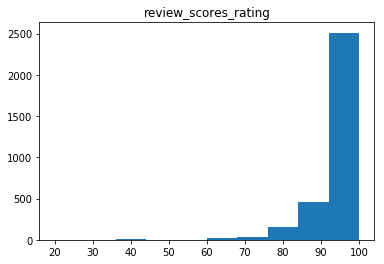

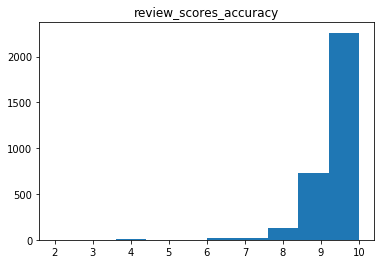

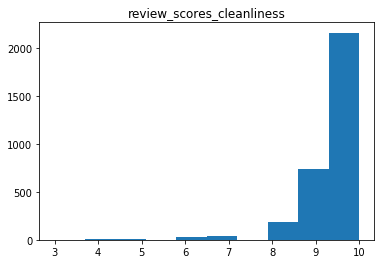

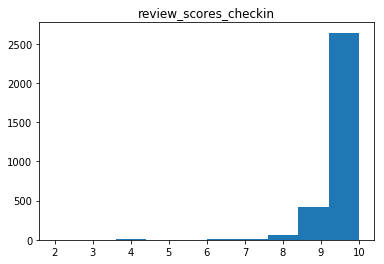

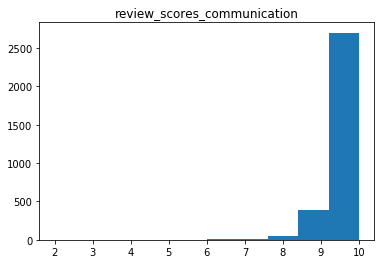

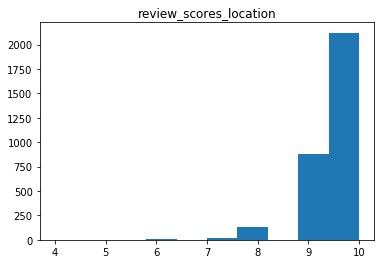

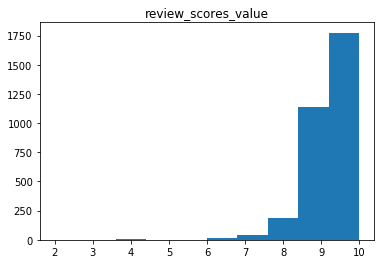

In [22]:
cols = reviews_list.columns[1:]
for col in cols:
    plt.figure()
    plt.hist(reviews_list[col].values)
    plt.title(str(col))

In [23]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [24]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null object
price         934542 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 42.5+ MB


In [25]:
calendar.price.dropna(inplace=True)

In [26]:
calendar['available'].replace({'t': True, 'f': False}, inplace=True)

In [27]:
#calendar['price'] = calendar['price'].fillna('$0.00')

In [28]:
#calendar['price'] = calendar['price'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')

In [29]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,$85.00
1,241032,2016-01-05,True,$85.00
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


In [30]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null bool
price         934542 non-null object
dtypes: bool(1), datetime64[ns](1), int64(1), object(1)
memory usage: 29.7+ MB


In [31]:
calendar.sort_values(by='date', inplace=True)

In [32]:
calendar[calendar['available'] == True].count()

listing_id    934542
date          934542
available     934542
price         934542
dtype: int64

In [33]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,$85.00
1171285,7109735,2016-01-04,False,NaN
442380,5736082,2016-01-04,False,NaN
997180,7435912,2016-01-04,True,$70.00
1203040,1777158,2016-01-04,False,NaN


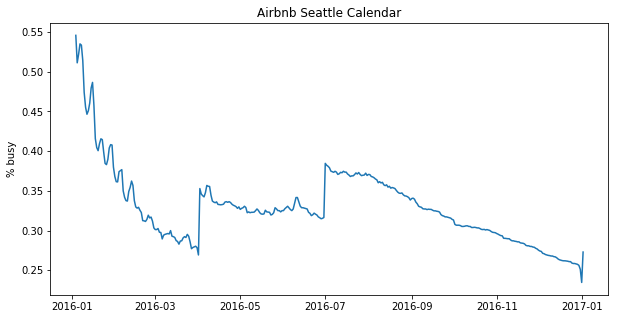

In [34]:
calendar_new = calendar[['date', 'available']]
calendar_new['busy'] = calendar_new.available.map( lambda x: 0 if x == True else 1)
calendar_new = calendar_new.groupby('date')['busy'].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb Seattle Calendar')
plt.ylabel('% busy')
plt.show();

In [35]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null bool
price         934542 non-null object
dtypes: bool(1), datetime64[ns](1), int64(1), object(1)
memory usage: 43.9+ MB


In [36]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 57 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      3818 non-null object
latitude                            38

In [37]:
listings.head(3)

,id,name,summary,space,description,experiences_offered,transit,host_total_listings_count,street,neighbourhood,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,3.0,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Convenient bus stops are just down the block, ...",6.0,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,...,10.0,10.0,10.0,f,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,A bus stop is just 2 blocks away. Easy bus a...,2.0,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,...,10.0,10.0,10.0,f,f,strict,f,f,2,1.15


In [38]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB


# Analyze Text Data from Listings and Reviews

In [39]:
listings.head(3)

,id,name,summary,space,description,experiences_offered,transit,host_total_listings_count,street,neighbourhood,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,3.0,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Convenient bus stops are just down the block, ...",6.0,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,...,10.0,10.0,10.0,f,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,A bus stop is just 2 blocks away. Easy bus a...,2.0,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,...,10.0,10.0,10.0,f,f,strict,f,f,2,1.15


In [40]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 57 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      3818 non-null object
latitude                            38

In [41]:
listings_text = listings[['name', 'summary', 'space', 'description', 'transit', 'amenities']]

In [42]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [43]:
reviews.rename(index=str, columns={"id": "review_id"}, inplace=True)

In [44]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
review_id        84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.5+ MB


In [45]:
reviews.listing_id.nunique()

3191

In [46]:
reviews.dropna(inplace=True)

In [47]:
ids = list(reviews.listing_id.unique())

In [48]:
review_dict = {}
for i in ids:
    df = reviews.loc[reviews['listing_id'] == i]
    review_dict[i] = {}
    review_dict[i]['reviewer_id'] = (df['reviewer_id'])
    review_dict[i]['reviewer'] = (df['reviewer_name'])
    review_dict[i]['comments'] = (df['comments'])

In [49]:
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/steeznation/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [51]:
reviews.fillna('', inplace=True)

In [52]:
reviews.isna().sum()

listing_id       0
review_id        0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [53]:
reviews_text = list(reviews.comments)
reviews_text
all(type(r)==str for r in reviews_text)
for r in reviews_text:
    if type(r) == str:
        continue
    else:
        print(r)
        print(type(r))
        print("-"*50)
        print("\n")

In [54]:
all(type(r)==str for r in reviews_text)

True

In [55]:
reviews_text

['Cute and cozy place. Perfect location to everything! ',
 'Kelly has a great room in a very central location. \r\nBeautiful building , architecture and a style that we really like. \r\nWe felt guite at home here and wish we had spent more time.\r\nWent for a walk and found Seattle Center with a major food festival in progress. What a treat.\r\nVisited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW.  Thanks for a great stay.',
 'Very spacious apartment, and in a great neighborhood.  This is the kind of apartment I wish I had!\r\n\r\nDidn\'t really get to meet Kelly until I was on my out, but she was always readily available by phone. \r\n\r\nI believe the only "issue" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday',
 "Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the

In [56]:
tokens = reviews['comments'].apply(word_tokenize)
%notify

<IPython.core.display.Javascript object>

In [57]:
tokens

0        [Cute, and, cozy, place, ., Perfect, location,...
1        [Kelly, has, a, great, room, in, a, very, cent...
2        [Very, spacious, apartment, ,, and, in, a, gre...
3        [Close, to, Seattle, Center, and, all, it, has...
4        [Kelly, was, a, great, host, and, very, accomm...
5        [Kelly, was, great, ,, place, was, great, ,, j...
6        [Kelly, was, great, !, Very, nice, and, the, n...
7        [hola, all, bnb, erz, -, Just, left, Seattle, ...
8        [Kelly, 's, place, is, conveniently, located, ...
9        [The, place, was, really, nice, ,, clean, ,, a...
10       [The, place, was, really, nice, ,, clean, and,...
11       [The, listing, was, exactly, as, described, !,...
12       [Very, welcoming, and, a, nicer, place, to, li...
13       [Great, location, ,, great, price, ,, great, h...
14       [Staying, at, Kelly, 's, was, easy, ., The, lo...
15       [Kelly, was, an, amazing, host, who, made, the...
16       [Despite, our, late, booking, request, ,, Rach.

# Sentiment Intensity Analysis of Reiews

In [58]:
import nltk.sentiment.vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/steeznation/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [59]:
test_1 = 'Room was nice. Room was not awful at all. I really liked it.'
test_2 = 'I detest this room. It was terrible. I will not stay there any longer.'

vader_polarity_compound = lambda s: (SentimentIntensityAnalyzer().polarity_scores(s))['compound']
vader_polarity_compound(test_1), vader_polarity_compound(test_2)

(0.8112, -0.4767)

In [60]:
print(reviews.comments.isnull().sum())
reviews.dropna(subset=['comments'], how='any', axis=0, inplace=True)
reviews.comments.isnull().sum()

0


0

In [61]:
if not os.path.exists ('seattle_reviews.h5'):
    %%time
    reviews['polarity'] = reviews.comments.map(vader_polarity_compound)
    reviews.to_hdf('seattle_reviews.h5', key='seattle_reviews', mode='w')

In [62]:
seattle_reviews = pd.read_hdf('seattle_reviews.h5', 'seattle_reviews')

In [63]:
seattle_reviews.polarity.describe()

count    84831.000000
mean         0.884985
std          0.221284
min         -0.997500
25%          0.898250
50%          0.954100
75%          0.977400
max          0.999700
Name: polarity, dtype: float64

In [64]:
seattle_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783


In [65]:
sort_seattle_reviews = seattle_reviews.sort_values(by='polarity')
sort_seattle_reviews.reset_index(drop=True, inplace=True)

In [66]:
sort_seattle_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity
0,258571,37845285,2015-07-11,31512581,Ysett,Wir sind 5 Nächte geblieben. Und es ist eine A...,-0.9975
1,1018204,5122651,2013-06-13,6775393,Heidi,"leider war esnicht so fein, da die unterkunft ...",-0.9970
2,4577542,44747593,2015-08-29,25805389,Sebastian,"Die Unterkunft war sehr schön und genau so, wi...",-0.9961
3,3291777,14760768,2014-06-25,16881604,Annar,Melissa replied to our request and approved bu...,-0.9956
4,1775016,21243349,2014-10-13,20072109,Anna,Staying at Robert’s place was a nightmare. At ...,-0.9941


In [67]:
sort_seattle_reviews.tail()

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity
84826,1048798,18062943,2014-08-21,5244721,Barb,If you are looking for a fabulous place to sta...,0.9994
84827,585418,30257274,2015-04-19,26386980,Victor,"Angela TOTALLY lived up to her ""reputation"" in...",0.9995
84828,5272327,50488125,2015-10-12,363242,Mika,This was such a great trip and experience!\r\n...,0.9995
84829,1048798,41201991,2015-08-05,31934586,Sandy,This was our third trip to Seattle to visit ou...,0.9995
84830,4429898,23827888,2014-12-11,13997957,Aindrea,Awesome location about a mile from downtown Ba...,0.9997


In [68]:
negative = sort_seattle_reviews[:849]
negative.tail()

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity
844,254340,14390095,2014-06-18,1400390,June,I have stayed here several times and each time...,-0.0102
845,5021969,48469891,2015-09-26,36582242,Arturo,"Experience was Good overall, the building is o...",-0.0096
846,5078244,30113047,2015-04-17,1503536,Tjark,Alberto was a very nice and helpful host. The ...,-0.0056
847,1198884,44676482,2015-08-28,39880231,Tommy,Very nice place. Really close to the conventio...,-0.0031
848,1097520,17511822,2014-08-13,58602,Julia,very nice place. a few things that went wrong...,-0.0018


In [69]:
sort_seattle_reviews[7998:8008]

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity
7998,279063,36069664,2015-06-24,33500132,Jenny,Very good staying here. Quiet and convenient. ...,0.7496
7999,5261239,53944294,2015-11-14,20971142,Meghann,Was very easy to access the apartment. Very go...,0.7496
8000,1171574,29509679,2015-04-08,2772734,Shane,I loved staying here! Phil was so accommodatin...,0.7497
8001,3424991,42392677,2015-08-13,31991777,Seth,Great location and good price. I never met Mi...,0.7497
8002,1450262,37939534,2015-07-12,11106271,Eric,"My family and I stayed at Sarah's house twice,...",0.7498
8003,47196,231120,2011-04-18,506322,Timothy,Faye & I found Shalini & Eric's ground floor s...,0.7500
8004,7710713,47839279,2015-09-21,43814436,Francis,Everything was perfect and we felt welcomed in...,0.7500
8005,6482409,45670933,2015-09-05,36678106,Jim,Made the reservation after reading other revie...,0.7500
8006,2263643,50999663,2015-10-16,6791976,Marius,"Tessa is a wonderful host, I felt welcomed and...",0.7500
8007,2686374,54863290,2015-11-25,6287817,Stephan,I had a group of 4 people stay here for a long...,0.7500


In [70]:
sub_pt75 = sort_seattle_reviews[:8003]
top_pt75 = sort_seattle_reviews[8003:]

## All Reviews Graphically

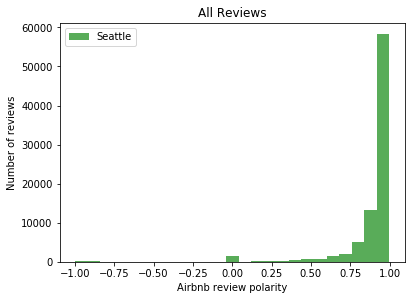

In [71]:
plt.hist(seattle_reviews.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb review polarity')
plt.ylabel('Number of reviews')
plt.title('All Reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

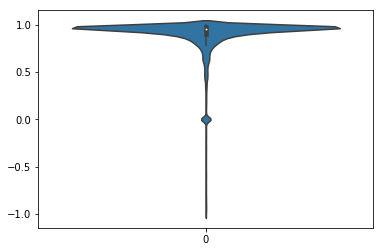

In [72]:
sns.violinplot(data = seattle_reviews.polarity);

## All Reviews with Negative Sentiment

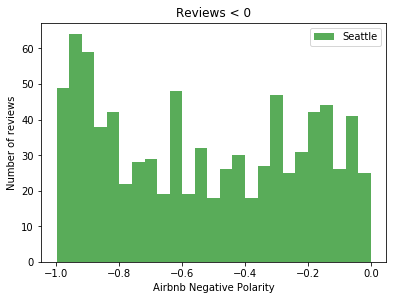

In [73]:
plt.hist(negative.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb Negative Polarity')
plt.ylabel('Number of reviews')
plt.title('Reviews < 0')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

## All Reviews with Sentiment < 0.75

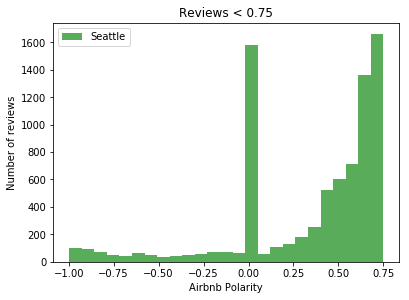

In [74]:
plt.hist(sub_pt75.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb Polarity')
plt.ylabel('Number of reviews')
plt.title('Reviews < 0.75')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

## All Reviews with Sentiment >= 0.75

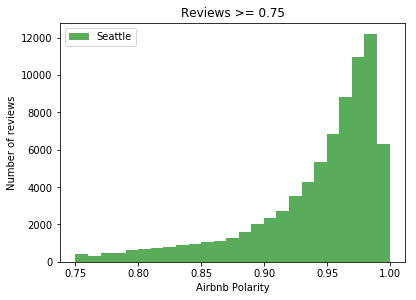

In [75]:
plt.hist(top_pt75.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb Polarity')
plt.ylabel('Number of reviews')
plt.title('Reviews >= 0.75')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

# Now Need to Find Which Locations Received Poor Reviews

In [76]:
print("Number of Negatively Reviewed Air BnB Locations:", negative.listing_id.nunique())
# Create list of 'IDs' for Negative Reviews
negative_locs = list(negative.listing_id.unique())

Number of Negatively Reviewed Air BnB Locations: 559


In [77]:
print("Number of Locations Reviewed <0.75:", sub_pt75.listing_id.nunique())
sub_75_locs = list(sub_pt75.listing_id.unique())

Number of Locations Reviewed <0.75: 2037


In [78]:
print("Number of Locations Reviewed >0.75:", top_pt75.listing_id.nunique())
top_75_locs = list(top_pt75.listing_id.unique())

Number of Locations Reviewed >0.75: 3134


In [79]:
print("Total Number of Locations:", seattle_reviews.listing_id.nunique())
all_locs = list(seattle_reviews.listing_id.unique())

Total Number of Locations: 3191


In [80]:
listings.head(2)

,id,name,summary,space,description,experiences_offered,transit,host_total_listings_count,street,neighbourhood,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,3.0,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Convenient bus stops are just down the block, ...",6.0,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,...,10.0,10.0,10.0,f,f,strict,t,t,6,1.48


In [81]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 57 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      3818 non-null object
latitude                            38

In [113]:
negs = listings[['id', 'latitude', 'longitude']]
neg_ids = negative_locs
neg_dict = {}
for neg in neg_ids:
    df = negs.loc[negs['id'] == neg]
    neg_dict[neg] = {}
    neg_dict[neg]['lat'] = (df['latitude'])
    neg_dict[neg]['long'] = (df['longitude'])

In [114]:
(neg_dict)

{258571: {'lat': 2610    47.615967
  Name: latitude, dtype: float64, 'long': 2610   -122.326938
  Name: longitude, dtype: float64}, 1018204: {'lat': 837    47.605623
  Name: latitude, dtype: float64, 'long': 837   -122.308905
  Name: longitude, dtype: float64}, 4577542: {'lat': 912    47.61092
  Name: latitude, dtype: float64, 'long': 912   -122.31349
  Name: longitude, dtype: float64}, 3291777: {'lat': 789    47.658632
  Name: latitude, dtype: float64, 'long': 789   -122.317766
  Name: longitude, dtype: float64}, 1775016: {'lat': 2876    47.625634
  Name: latitude, dtype: float64, 'long': 2876   -122.324663
  Name: longitude, dtype: float64}, 26116: {'lat': 2945    47.617426
  Name: latitude, dtype: float64, 'long': 2945   -122.326756
  Name: longitude, dtype: float64}, 6115704: {'lat': 1540    47.610007
  Name: latitude, dtype: float64, 'long': 1540   -122.338016
  Name: longitude, dtype: float64}, 208356: {'lat': 1447    47.599081
  Name: latitude, dtype: float64, 'long': 1447   -12

In [97]:
crime_df = pd.read_csv('Data/seattle_crime/Seattle_Police_Department_911_Incident_Response.csv')

In [98]:
zones = crime_df[['Zone/Beat', 'District/Sector', 'Latitude', 'Longitude']]
zones.dropna(inplace=True)
zlist = list(zones['District/Sector'].unique())
z_dict = {}
for z in zlist:
    df = zones.loc[zones['District/Sector'] == z]
    z_dict[z] = {}
    z_dict[z]['Lat'] = (df['Latitude'].mean())
    z_dict[z]['Long'] = (df['Longitude'].mean())

In [99]:
zones.isna().sum()

Zone/Beat          0
District/Sector    0
Latitude           0
Longitude          0
dtype: int64

In [100]:
seattle_geo = '/Users/steeznation/Flatiron/Module05/capstone/seattle-boundaries-data/data/spd-beats.geojson'

seattle_coords = (47.6062, -122.3321)

In [120]:
# definition of the boundaries in the map
district_geo = seattle_geo
  
# calculating total number of incidents per district
crimedata = pd.DataFrame(crime_df['Zone/Beat'].value_counts().astype(float))
crimedata.to_json('crimeagg.json')
crimedata = crimedata.reset_index()
crimedata.columns = ['Beat', 'Number']

m = folium.Map(location=seattle_coords, zoom_start=11)
folium.Marker((47.60321842900001, -122.27233422425)).add_to(m)
folium.Choropleth(geo_data=seattle_geo,
                  data=crimedata,
                  columns=['Beat', 'Number'],
                  key_on='feature.properties.name',
                  fill_color='YlGnBu',
                  fill_opacity=0.8,
                  line_opacity=0.2,
                  bins=9,
                  name='Incidents per Beat',
                  legend_name='Incidents per Beat',
                  highlight=True).add_to(m)

for k, v in (neg_dict.items()):
    # print(k, list([v['Lat'], v['Long']]))
    folium.Marker([v['lat'], v['long']]).add_to(m)

folium.LayerControl().add_to(m)
plugins.ScrollZoomToggler().add_to(m)

m